In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

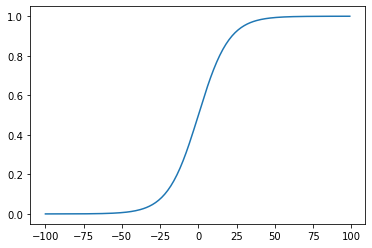

In [114]:
#sigmoid
def sigmoid(phase,amp, i):
    return 1/(1+np.exp(phase+amp*(-i)))

x, y = [i for i in range(-100, 100)], []
for i in x:
    y.append(sigmoid(0, 0.1, i))
plt.plot(x, y)

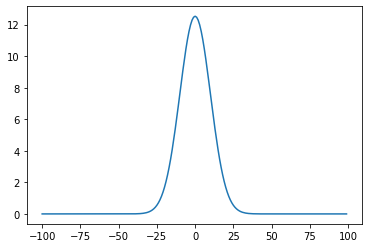

In [118]:
#sigma=phase, amp=mu
def gaussian(phase, amp, i):
    return (1/2*np.pi*amp**2)**(0.5)*(np.exp(-(i-phase)**2/2*amp**2))

x, y = [i for i in range(-100, 100)], []
for i in x:
    y.append(gaussian(0, 10, i/100))
plt.plot(x, y)

In [151]:
def sinus(phase, amp, x):
    return amp*np.sin(phase+x)

In [152]:
function=sinus

#generating function data
class FunctionTask():
    def __init__(self,amp,phase,min_x,max_x):
        self.phase=phase
        self.max_x=max_x
        self.min_x=min_x
        self.amp=amp 
    
    def sample_data(self,size=1):
        x=np.random.uniform(self.max_x,self.min_x,size)
        y=self.true_function(x)
        x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
        return x,y
  
    def true_function(self,x):
        y=function(self.phase,self.amp,x)
        return y

In [153]:
class FunctionDistribution():
  def __init__(self,min_amp,max_amp,min_phase,max_phase,min_x,max_x):
    self.min_amp=min_amp
    self.max_phase=max_phase
    self.min_phase=min_phase
    self.max_amp=max_amp
    self.min_x=min_x  #Pas de changement par rapport à précédemment
    self.max_x=max_x  #Pas de changement par rapport à précédemment
    
  def sample_task(self):
    amp = np.random.uniform(self.min_amp, self.max_amp)
    phase = np.random.uniform(self.min_phase, self.max_phase)
    return FunctionTask(amp, phase, self.min_x, self.max_x)

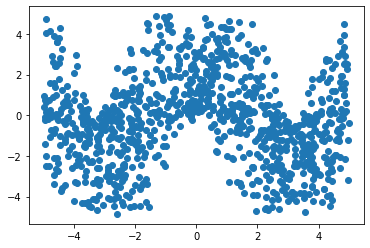

In [163]:
min_amp,max_amp,min_phase,max_phase,min_x,max_x = 0.1, 5, 0, np.pi, -5, 5

function_dist = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
X, Y = [], []
temp_x, temp_y = 0, 0

for i in range(1000):
    temp_x, temp_y = function_dist.sample_task().sample_data()
    X.append(temp_x)
    Y.append(temp_y)
plt.scatter(X, Y)

In [164]:
#defining our Function-net
class FunctionNet(nn.Module):
  def __init__(self):
    super(FunctionNet,self).__init__()
    self.net=nn.Sequential(OrderedDict([
            ('l1',nn.Linear(1,40)),
            ('relu1',nn.ReLU()),
            ('l2',nn.Linear(40,40)),
            ('relu2',nn.ReLU()),
            ('l3',nn.Linear(40,1))
        ]))
      
  # I implemented argforward() so that I could use a set of custom weights for evaluation. 
  # This is important for the "inner loop" in MAML where you temporarily update the weights
  # of the network for a task to calculate the meta-loss and then reset them for the next meta-task.
  def argforward(self,x,weights): 
    x=F.linear(x,weights[0],weights[1])
    x=F.relu(x)
    x=F.linear(x,weights[2],weights[3])           
    x=F.relu(x)
    x=F.linear(x,weights[4],weights[5])
    return x

In [165]:
class FunctionMAML():
  def __init__(self,net,alpha,beta,tasks,k,num_metatasks):
    self.net=net
    self.weights=list(net.parameters())
    self.alpha=alpha
    self.beta=beta
    self.tasks=tasks
    self.k=k 
    self.num_tasks_meta=num_metatasks #nombre de tâches que l'on utilise
    self.criterion=nn.MSELoss()  #criterion just to chose
    self.meta_optimiser=torch.optim.Adam(self.weights,self.beta)
    self.meta_losses=[]
    self.plot_every =100
    self.print_every = 10000
    self.num_metatasks=num_metatasks

  def inner_loop(self,task):
    temp_weights=[w.clone() for w in self.weights]
    x,y=task.sample_data(size=self.k) #sampling D
    x=x.to(device)
    y=y.to(device)
    output=self.net.argforward(x,temp_weights)
    loss=self.criterion(output,y)/self.k
    grads=torch.autograd.grad(loss,temp_weights)
    temp_weights=[w-self.alpha*g for w,g in zip(temp_weights,grads)] #temporary update of weights
    x,y=task.sample_data(size=self.k) #sampling D'
    x=x.to(device)
    y=y.to(device)
    output=self.net.argforward(x,temp_weights)
    metaloss=self.criterion(output,y)/self.k
    return metaloss
  
  def outer_loop(self,num_epochs):
    total_loss=0
    for epoch in range(1,num_epochs+1): #Correspond au "While not done"
      metaloss_sum=0
      for i in range(self.num_metatasks): 
        task=self.tasks.sample_task()
        metaloss=self.inner_loop(task)
        metaloss_sum+=metaloss
      metagrads=torch.autograd.grad(metaloss_sum,self.weights)
      #important step
      for w,g in zip(self.weights,metagrads):
        w.grad=g
      ###############
      self.meta_optimiser.step()
      total_loss+=metaloss_sum.item()/self.num_metatasks
      if epoch % self.print_every == 0:
        print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
      if epoch%self.plot_every==0:
        self.meta_losses.append(total_loss/self.plot_every)
        total_loss = 0

In [178]:
function_tasks=FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
net=FunctionNet()
net=net.to(device)
maml=FunctionMAML(net,alpha=0.01,beta=0.001,tasks=function_tasks,k=5,num_metatasks=10)

In [179]:
maml.outer_loop(num_epochs=10000)

10000/10000. loss: 0.22269711744785303


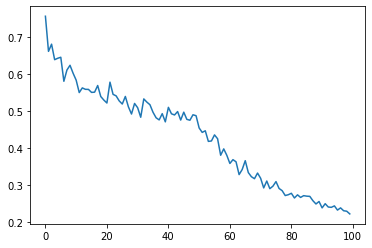

In [180]:
plt.plot(maml.meta_losses)

In [181]:
def test(og_net,x,y,lr,optim=torch.optim.SGD):
  axis=np.linspace(-5,5,1000)
  axis=torch.tensor(axis,dtype=torch.float)
  axis=axis.to(device)
  dummy_net = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
  dummy_net=dummy_net.to(device)
  dummy_net.load_state_dict(og_net.state_dict())
  loss_fn=nn.MSELoss()
  opt=optim(dummy_net.parameters(),lr=lr)
  num_shots=10
  k=x.shape[0]
  losses=[]
  outputs={}
  for i in range(num_shots):
    out=dummy_net(x)
    loss=loss_fn(out,y)
    losses.append(loss.item())
    dummy_net.zero_grad()
    loss.backward()
    opt.step()
  outputs['minitrained']= dummy_net(axis.view(-1, 1)).detach().cpu().clone().numpy()
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
  print(losses)
  return outputs,axis

In [182]:
def plot_test(og_net,x,y,task,optim=torch.optim.SGD,lr=0.01):
  outputs,axis=test(og_net,x,y,lr,optim)
  plt.figure(figsize=(10,5))
  plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
  plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
  plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
  plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
  plt.legend(loc='lower right')
  plt.show()

[8.204963684082031, 230.34701538085938, 495.23687744140625, 211749.71875, 625611.625, 1.109787108239803e+24, inf, nan, nan, nan]


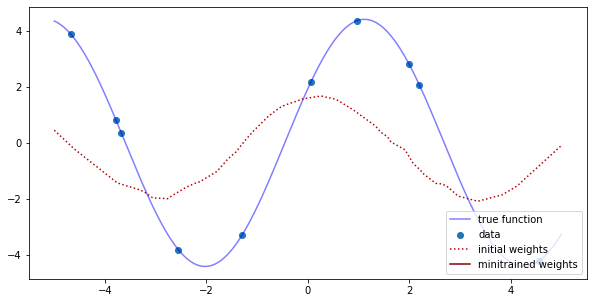

In [183]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

[7.369085788726807, 240632.65625, 464975273394176.0, inf, nan, nan, nan, nan, nan, nan]


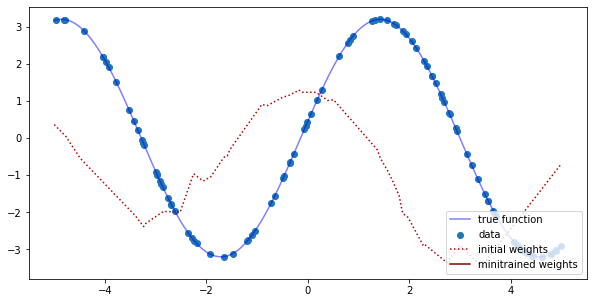

In [177]:
K=100
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

[0.03647676855325699, 0.03512261435389519, 0.03456742689013481, 0.03412383422255516, 0.03370531275868416, 0.033301834017038345, 0.032910894602537155, 0.03253205120563507, 0.03216421231627464, 0.03180745244026184]


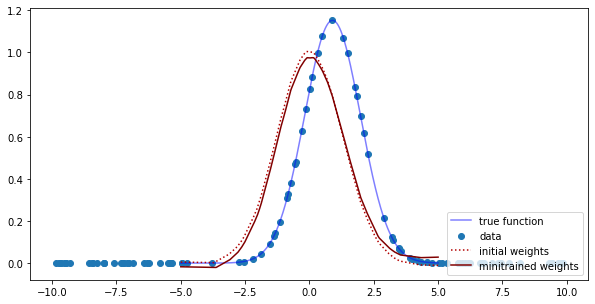

In [134]:
K=100
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

[0.013343180529773235, 0.01318391039967537, 0.013055825605988503, 0.012937065213918686, 0.012822230346500874, 0.01270967349410057, 0.012598930858075619, 0.012489641085267067, 0.01238179299980402, 0.012275266461074352]


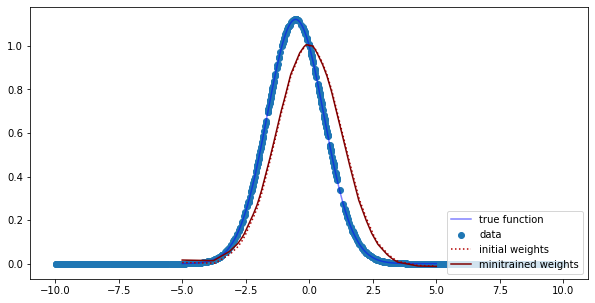

In [135]:
K=1000
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

## For testing